In [13]:
import numpy as np
from pandas_dq import dq_report
import pandas as pd
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import make_scorer
import lightgbm as lgb
import mlflow
from mlflow.tracking import MlflowClient
import json


pd.set_option('display.max_columns', 10)
pd.set_option('display.max_rows', 10)


In [10]:
pd.reset_option('^display.', silent=True)

In [2]:
mlflow.set_experiment("House_Prices")
with mlflow.start_run():
    run = mlflow.active_run()
    run_id = run.info.run_id

In [80]:
client = MlflowClient()
experiment_id = client.get_experiment_by_name("House_Prices").experiment_id

In [6]:


mlflow.start_run(
    run_name="RUN_1",
    experiment_id=experiment_id,
    tags={"version": "v1", "priority": "P1"},
    description="KBestSelector",
)

<ActiveRun: >

In [8]:
housePrices = pd.read_csv('csv_files/housePricesTrain.csv')
housePrices = housePrices.drop(columns=['Id'])


In [14]:
pd.get_option('display.max_rows')

10

As seen bellow, our train dataset contains 1460 lines and 81 columns/features. 

In [3]:
housePrices.shape

(1460, 80)

A quick analysis using dq_report will allow us to better understand our dataset. 

In [15]:
X_analysis = dq_report(housePrices, verbose=2)

/var/folders/25/8m9ycrtx2kv84b8szslr4jfc0000gp/T/ipykernel_36981/2887496668.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  X_analysis = dq_report(housePrices, verbose=2)


,Data Type,Missing Values%,Unique Values%,Minimum Value,Maximum Value,DQ Issue
MSSubClass,int64,0.000000,1,20,190,has 103 outliers greater than upper bound (145.0) or lower than lower bound(-55.0). Cap them or remove them.
MSZoning,object,0.000000,0,C (all),RM,"3 rare categories: ['FV', 'RH', 'C (all)']. Group them into a single category or drop the categories."
LotFrontage,float64,17.739726,NA,21.000000,313.000000,"259 missing values. Impute them with mean, median, mode, or a constant value such as 123., has 88 outliers greater than upper bound (111.5) or lower than lower bound(27.5). Cap them or remove them."
LotArea,int64,0.000000,73,1300,215245,has 69 outliers greater than upper bound (17673.5) or lower than lower bound(1481.5). Cap them or remove them.
Street,object,0.000000,0,Grvl,Pave,1 rare categories: ['Grvl']. Group them into a single category or drop the categories.
Alley,object,93.767123,0,nan,nan,"1369 missing values. Impute them with mean, median, mode, or a constant value such as 123., Mixed dtypes: has 2 different data types: float, object,"
LotShape,object,0.000000,0,IR1,Reg,"2 rare categories: ['IR2', 'IR3']. Group them into a single category or drop the categories."
LandContour,object,0.000000,0,Bnk,Lvl,"3 rare categories: ['Bnk', 'HLS', 'Low']. Group them into a single category or drop the categories."
Utilities,object,0.000000,0,AllPub,NoSeWa,1 rare categories: ['NoSeWa']. Group them into a single category or drop the categories.
LotConfig,object,0.000000,0,Corner,Inside,"2 rare categories: ['FR2', 'FR3']. Group them into a single category or drop the categories."


Many of the categorical columns represent qualities that can be ordered. We will be transforming then bellow. This will allow us to reduce the dimensionality of the resulting one-hot encoded matrix. 

In [16]:
X_reduced = housePrices.drop(columns=['SalePrice'])
y_train = housePrices['SalePrice']

In [17]:
X_reduced = X_reduced.fillna(0) #Substituiremos os valores NaN por '0', para que a ordem seja preservada 
                            # nas variáveis categóricas.

# Dicionário
mapping = {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5, 
           'No': 1, 'Mn': 2, 'Av': 3, 
           'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6, 
           'RFn': 2, 'Fin': 3
           }
##      
##       Ex   Excellent          GLQ   Good Living Quarters         Fin	Finished
##       Gd   Good               ALQ   Average Living Quarters      RFn	Rough Finished
##       TA   Average/Typical    Rec   Average Rec Room            
##       Fa   Fair               LwQ   Low Quality
##       Po   Poor               Unf   Unfinished
##
##

X_reduced = X_reduced.replace(mapping)

In [18]:
X_reducedDummies = pd.get_dummies(X_reduced)
scaler = StandardScaler()
X_reducedScaled = scaler.fit_transform(X_reducedDummies)

In [19]:
selector = SelectKBest(score_func=f_regression, k=20)


selector.fit(X_reducedDummies, y_train)

selector.fit_transform(X_reducedDummies, y_train)

selected = selector.get_support()

In [20]:
feature_scores = dict(zip(X_reducedDummies.columns[selected], selector.scores_))

feature_scores_dict = pd.DataFrame.from_dict(feature_scores, orient='index').sort_values(by=0, ascending=False)
feature_scores_dict = feature_scores_dict.to_dict()[0] #Ordered Dictionary

In [40]:
# Save the dictionary to a JSON file
with open('feature_scores_dict.json', 'w') as file:
    json.dump(feature_scores_dict, file)

In [21]:
X_Kbest = X_reducedDummies[X_reducedDummies.columns[selected]]

In [54]:
correlations = X_Kbest.corr()

# Step 1: Drop diagonal entries
corr_df = correlations.where(np.triu(np.ones(correlations.shape), k=1).astype(np.bool))

# Step 2: Unstack to get a Series of correlation values
corr_series = corr_df.unstack()

# Step 3: Sort the Series in descending order
corr_series_sorted = corr_series.sort_values(ascending=False)

# Print the sorted correlation values
corr_series_sortedDF = pd.DataFrame(corr_series_sorted)

/var/folders/25/8m9ycrtx2kv84b8szslr4jfc0000gp/T/ipykernel_4669/3590309826.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  corr_df = correlations.where(np.triu(np.ones(correlations.shape), k=1).astype(np.bool))


In [22]:
X_Kbest

,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,...,GarageFinish,GarageCars,GarageArea,Neighborhood_NridgHt,Foundation_PConc
0,7,2003,2003,196.0,4,...,2,2,548,0,1
1,6,1976,1976,0.0,3,...,2,2,460,0,0
2,7,2001,2002,162.0,4,...,2,2,608,0,1
3,7,1915,1970,0.0,3,...,1,3,642,0,0
4,8,2000,2000,350.0,4,...,2,3,836,0,1
...,...,...,...,...,...,...,...,...,...,...,...
1455,6,1999,2000,0.0,3,...,2,2,460,0,1
1456,6,1978,1988,119.0,3,...,1,2,500,0,0
1457,7,1941,2006,0.0,5,...,2,1,252,0,0
1458,5,1950,1996,0.0,3,...,1,1,240,0,0


In [41]:
mlflow.log_artifact(local_path='feature_scores_dict.json', artifact_path='dictionary')


In [43]:
mlflow.log_param('Score function', 'f_regression')

'f_regression'

In [1]:
X_Kbest

NameError: name 'X_Kbest' is not defined

In [15]:
correlations = X_Kbest.corr()


In [16]:
correlations

,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,BsmtQual,TotalBsmtSF,HeatingQC,1stFlrSF,GrLivArea,FullBath,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageFinish,GarageCars,GarageArea,Neighborhood_NridgHt,Foundation_PConc
OverallQual,1.000000,0.572323,0.550684,0.407252,0.726278,0.629379,0.537808,0.457083,0.476224,0.593007,0.550600,0.673331,0.427452,0.396765,0.490788,0.556863,0.600671,0.562022,0.368724,0.568211
YearBuilt,0.572323,1.000000,0.592855,0.311600,0.598160,0.602797,0.391452,0.448855,0.281986,0.199010,0.468271,0.530165,0.095589,0.147716,0.224545,0.595781,0.537850,0.478954,0.268898,0.651199
YearRemodAdd,0.550684,0.592855,1.000000,0.176529,0.587318,0.515013,0.291066,0.550017,0.240379,0.287389,0.439046,0.625316,0.191740,0.112581,0.196103,0.444541,0.420622,0.371600,0.243558,0.569728
MasVnrArea,0.407252,0.311600,0.176529,1.000000,0.345329,0.277490,0.360067,0.157130,0.339850,0.388052,0.272999,0.282620,0.279568,0.247015,0.274950,0.275921,0.361945,0.370884,0.295720,0.189236
ExterQual,0.726278,0.598160,0.587318,0.345329,1.000000,0.565558,0.470580,0.520027,0.397835,0.435986,0.483949,0.716122,0.297903,0.249335,0.361798,0.519054,0.526390,0.495778,0.392421,0.604901
BsmtQual,0.629379,0.602797,0.515013,0.277490,0.565558,1.000000,0.564299,0.397169,0.293598,0.327956,0.371243,0.510938,0.185846,0.229635,0.307337,0.485184,0.449194,0.406109,0.305480,0.561151
TotalBsmtSF,0.537808,0.391452,0.291066,0.360067,0.470580,0.564299,1.000000,0.265682,0.819530,0.454868,0.323722,0.432630,0.285573,0.339519,0.347615,0.371514,0.434585,0.486665,0.293445,0.307701
HeatingQC,0.457083,0.448855,0.550017,0.157130,0.520027,0.397169,0.265682,1.000000,0.189888,0.254644,0.333499,0.504228,0.164904,0.129689,0.207500,0.392244,0.325347,0.295462,0.203891,0.529073
1stFlrSF,0.476224,0.281986,0.240379,0.339850,0.397835,0.293598,0.819530,0.189888,1.000000,0.566024,0.380637,0.387027,0.409516,0.410531,0.407887,0.334139,0.439317,0.489782,0.254693,0.197188
GrLivArea,0.593007,0.199010,0.287389,0.388052,0.435986,0.327956,0.454868,0.254644,0.566024,1.000000,0.630012,0.420563,0.825489,0.461679,0.469947,0.353021,0.467247,0.468997,0.179892,0.292764


In [30]:
custom_palette = sns.color_palette("coolwarm", n_colors=256, sa)


<AxesSubplot: >

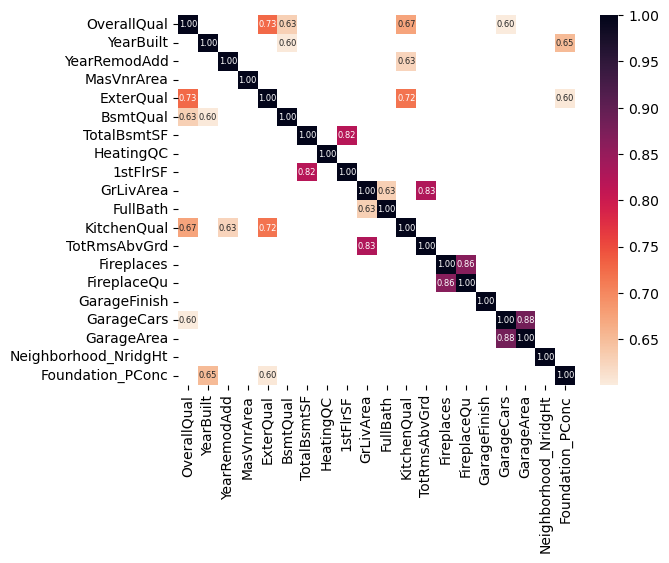

In [86]:
sns.heatmap(correlations, annot=True, cmap="rocket_r", fmt=".2f", annot_kws={"size": 6}, mask=correlations < 0.6)


In [87]:
mlflow.log_artifact(local_path='Kbest_stronger_correlation.png', artifact_path='charts and graphs')


In [85]:
plt.figure(figsize=(20, 16))

<Figure size 2000x1600 with 0 Axes>

<Figure size 2000x1600 with 0 Axes>

In [81]:
mlflow.start_run(
    run_name="Kbest_correlation",
    experiment_id=experiment_id,
    tags={"version": "v1", "priority": "P1"},
    description="KBest Feature Correlation",
)

<ActiveRun: >

In [79]:
experiment_id = client.get_experiment_by_name("House_Prices").experiment_id

NameError: name 'client' is not defined

<AxesSubplot: xlabel='SalePrice', ylabel='Density'>

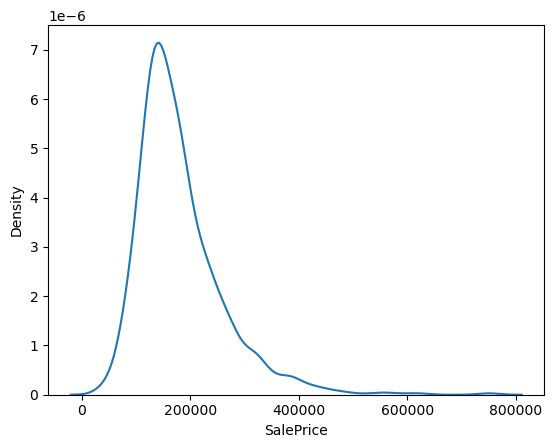

In [102]:
sns.kdeplot(test.sort_values())

In [93]:
test = housePrices['SalePrice']

In [98]:
test.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64